In [1]:
from Image_generation.image1D import CustomUnlabeledDataset
import diffml
import torch
from diffml.utils import plot_field
import numpy as np
import matplotlib.pyplot as plt
import math as m

# Difine PSF

In [3]:
from scipy import signal

propagation_algorithm = "riemann"
device = "cpu"

dim_lens = 2000 # Number of pixels in the lens
dim_in = 2000  # Number of pixels in the input plane
dim_out = 2000 # Number of pixels in the output plane
pixel_size = 1e-6  # meters
wavelength = 700e-9
samples_per_pixel = 1
NA=1e-3
unit = wavelength/(NA)
sigma = 0.21 * wavelength / NA

x = np.linspace(-dim_lens*pixel_size/2, dim_lens*pixel_size/2, num=dim_lens)
psf = 1 / ((2 * m.pi) ** 0.25 * m.sqrt(sigma)) * np.exp(-x ** 2 / (4 * sigma ** 2))


def propagate(source, PSF):
    """
    Calculates the field distribution in image plane for a given field distribution at the source and Point Spread Function
    """
    image = signal.fftconvolve(source, PSF, mode='same')
    image_norm = image / np.sqrt(np.sum(np.abs(image)**2) +1e-10) # normalize image
    return image_norm


# Print relavent physical properties.
print(f"unit= {unit}, \nRayleigh limit = {1.22*unit}, \nsigma = {0.42*unit}, \nNA = {NA}")
print(f"\nImage size: {dim_in*pixel_size/unit} unit")

unit= 0.0007, 
Rayleigh limit = 0.0008539999999999999, 
sigma = 0.000294, 
NA = 0.001

Image size: 2.857142857142857 unit


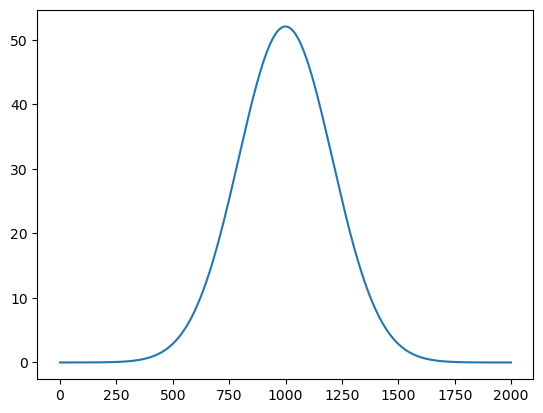

In [4]:
plt.plot(psf)

# Generate dataset

In [5]:
from Image_generation.image1D import SourceImage1D, add_guassian, normalise_img_int, randomize_img_int, CustomUnlabeledDataset

image_cls = SourceImage1D(dim_in, img_size=dim_in*pixel_size)

double_source, separations = image_cls.generate_double_slit(42000, d_min=0*unit, d_max=0.3*unit)
separations = torch.tensor(separations/unit)

single_source = image_cls.single_slit()

tensor(0.2687, dtype=torch.float64)


2000

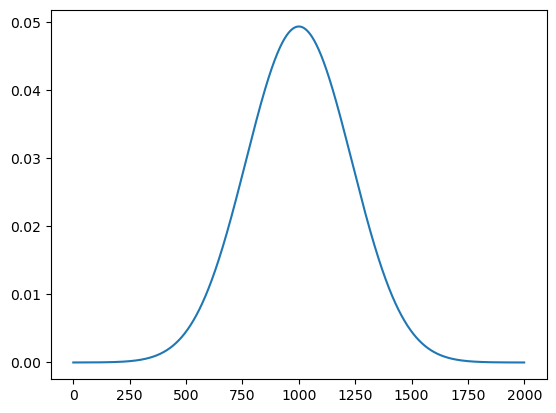

In [6]:
img_num = 18
test = propagate(double_source[img_num], psf)
#plt.plot(double_source[img_num])
plt.plot(test)
print(separations[img_num])
len(test)

# Pass Through PSF

In [7]:
double_slits = []
batch_size = 100

for i in range(0, len(double_source)):
    double_image = propagate(double_source[i], psf)
    double_slits.append(double_image)
    
single_slit = propagate(single_source, psf)

In [8]:
double_slits = torch.tensor(double_slits, dtype=torch.cfloat)
single_slit = torch.tensor(single_slit, dtype=torch.cfloat)

C:\Users\TF\AppData\Local\Temp\ipykernel_22980\3933798702.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  double_slits = torch.tensor(double_slits, dtype=torch.cfloat)


In [9]:
double_slits.size(0)

42000

# Load Dataset for training

In [91]:
from torch.utils.data import DataLoader, random_split

single_slits = single_slit.repeat(3000,1).to('cuda')

# Normalise intensity
input_intensity = 1e4
double_slits = normalise_img_int(double_slits, pixel_size, input_intensity)
single_slits = normalise_img_int(single_slits, pixel_size, input_intensity)

# Randomize intensity
# input_intensity = 5000*torch.rand(double_slits.size(0)) + 5000
# double_slits = randomize_img_int(double_slits, pixel_size, input_intensity.unsqueeze(1))

# add noise
total_noise = 0
double_slits = add_guassian(double_slits, total_noise)
single_slits = add_guassian(single_slits, total_noise)

images = double_slits
labels = separations

dataset = CustomUnlabeledDataset(images, labels)
dataset = DataLoader(dataset, shuffle=True)

train_set, val_set = random_split(dataset.dataset, [30000, 12000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=30, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=30, shuffle=False)

In [192]:
# Dataset for classification

#15000 single img and 15000 double img needed for clsf 
single_slits_clsf = single_slit.repeat(15000,1)
single_slits_clsf = randomize_img_int(single_slits_clsf, pixel_size, input_intensity[:15000].unsqueeze(1))

image_clsf = torch.cat((double_slits[:15000].to(device), single_slits_clsf.to(device)), dim=0)

# The labels for the two region detection
ones = torch.ones(15000)
zeros = torch.zeros(15000)
# ones_zeros = torch.stack((ones, zeros), dim=1)
# zeros_ones = torch.stack((zeros, ones), dim=1)
labels_clsf = torch.cat((ones, zeros), dim=0)

dataset_clsf = CustomUnlabeledDataset(image_clsf, labels_clsf)
dataset_clsf = DataLoader(dataset_clsf, shuffle=True)

train_set_clsf, val_set_clsf = random_split(dataset_clsf.dataset, [27000, 3000])

train_loader_clsf = torch.utils.data.DataLoader(train_set_clsf, batch_size=30, shuffle=True)
val_loader_clsf = torch.utils.data.DataLoader(val_set_clsf, batch_size=30, shuffle=False)

# Define model

In [12]:
from LinearNN import Linear

network_dimensions = [2000, 2000, 2000, 2000, 2000]
pixel_size = 1e-6
wavelength = 700e-9
layer_distance = 0.03
samples_per_pixel = 1
backend = "riemann"
device='cuda'

# Define the model
diffml_model = diffml.DONN(network_dimensions, pixel_size, wavelength, layer_distance, 
                           samples_per_pixel, backend, 
                           phase_modulation_init='constant' , amplitude_modulation_init = 'constant')

# Define a focusing diff_nn
focusing_model = diffml.DONN([2000, 500, 500], pixel_size, wavelength, layer_distance, 
                           samples_per_pixel, backend, phase_modulation_init='constant')


diffml_model.to(device)

DONN(
  (layers): Sequential(
    (0): InitialLayer(
      (light_propagation): LightPropagation(
        (backend): RiemannBackend()
      )
    )
    (1): DiffractionLayer(
      (light_propagation): LightPropagation(
        (backend): RiemannBackend()
      )
    )
    (2): DiffractionLayer(
      (light_propagation): LightPropagation(
        (backend): RiemannBackend()
      )
    )
    (3): DiffractionLayer(
      (light_propagation): LightPropagation(
        (backend): RiemannBackend()
      )
    )
  )
)

In [78]:
# Define the linear model
import torch.nn as nn

class Linear_mix(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim

        self.layer_stack = nn.Sequential(
            *[nn.Linear(input_dim, 100),
              nn.Softplus(),
              nn.Linear(100, 10),
              nn.ReLU(),
              nn.Linear(10, 10),
              nn.ReLU(),
              nn.Linear(10, 1),
              ]
        )

    def forward(self, x):
        x = self.layer_stack(x)
        return x


# Digital_NN_dim = [2000,2000,1]
digital_NN = Linear_mix(2000)

# Define Training Function

In [15]:
import torch.nn as nn

# output normalisation
Normalisation = 1


def calc_output(diff_model, digital_model, data, noise=True):
    '''
    
    Calculate the outputs of the model during training and validation.
    '''
    
    diff_model.to(device)
    digital_model.to(device)
    data = data.squeeze() 
    data.to(device)
    
#     # pass through diffNN
#     output_field = diff_model(data).squeeze()    
#     output_intensity = torch.abs(output_field)**2*pixel_size
#     total_output_intensity = torch.sum(output_intensity, dim=1)
    
    # for testing only digital NN 
    output_intensity = torch.abs(data)**2*pixel_size
    total_output_intensity = torch.sum(output_intensity, dim=1)
    
    # Apply Poisson noise to output of diffNN using reparametrization trick
    if noise:
        poisson_int = torch.poisson(output_intensity)
        noise = (poisson_int - output_intensity).detach().clone()
        output_intensity += noise

    # Pass through Digital NN
    output = digital_model(output_intensity).squeeze()
    output /= Normalisation
    return output, total_output_intensity, output_intensity

# Define training function

def train(diffml_model, digital_NN, noise, device, train_loader, optimizer_diff, optimizer_digital, epoch, tot_loss: list):
    diffml_model.train()
    digital_NN.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer_diff.zero_grad()
        optimizer_digital.zero_grad()
        
        output, total_output_intensity, _ = calc_output(diffml_model, digital_NN, data, noise)
        
        loss = nn.MSELoss()(output, target)
        loss.backward()
        
        optimizer_diff.step()
        optimizer_digital.step()
        if batch_idx % 100 == 0:
                print(f"Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} ({100.0 * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                tot_loss.append(loss.item())

# Training for Classification

In [204]:
# Parameters for analysis
normalisation = 1e1 # Scale up the output intensity to make output of NN trainable


# Define the outputs used to train
def calc_output_clsf(model, data, normalisation):
    '''
    
    Calculate the outputs of the model during training and validation.
    '''
    
    data = data.squeeze() 
    data.to(device)
    focusing_model.to(device)
    
    output_field = focusing_model(model(data)).squeeze()  
    input_intensity = torch.sum(torch.abs(data)**2, dim=1)*pixel_size
    output_intensity_distribution = torch.abs(output_field)**2
    # separate the output to two regions
    output_region = output_intensity_distribution[:]
    
    output_intensity = torch.sum(output_region, dim=1)*pixel_size/4
    
    ratio = 1/input_intensity * output_intensity
    output = nn.Tanh()(ratio*normalisation)
    return output, ratio, output_intensity

# Define training function

def train_clsf(model, device, train_loader, optimizer_model, optimizer_focus, epoch):
    model.train()
    model.to(device)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer_model.zero_grad()
        optimizer_focus.zero_grad()
        
        output, ratio, output_intensity = calc_output_clsf(model, data, normalisation)
        
        loss = nn.BCELoss()(output, target)
        loss.backward()
        optimizer_model.step()
        optimizer_focus.step()
        if batch_idx % 100 == 0:
                print(f"Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} ({100.0 * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

# Define validation function
def validate_clsf(model, device, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output, ratio, output_intensity = calc_output_clsf(model, data, normalisation)

            pred = (output > 0.5)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    accuracy = 100. * correct / total
    print(f"\nValidation set: Accuracy: {correct}/{total} ({accuracy:.0f}%)\n")
    return accuracy     

# Print output to check for normalisation and scaling

In [76]:
for i, (data, target) in enumerate(val_loader):
    diffml_model.eval()
    digital_NN.eval()
    data, target = data.to(device), target.to(device)
    output, output_intensity,_ = calc_output(diffml_model, digital_NN, data)
    
    if i == 0:
        print('        label, ouput, output intensity:')
        print(torch.stack((target, output, output_intensity), dim=1))
        break

        label, ouput, output intensity:
tensor([[1.6151e-01, 1.5497e-01, 1.0000e+06],
        [1.7866e-01, 1.5497e-01, 1.0000e+06],
        [2.3726e-01, 1.5497e-01, 1.0000e+06],
        [8.5757e-03, 1.5497e-01, 1.0000e+06],
        [9.8621e-02, 1.5497e-01, 1.0000e+06],
        [9.2904e-02, 1.5497e-01, 1.0000e+06],
        [1.9295e-01, 1.5497e-01, 1.0000e+06],
        [2.3012e-01, 1.5497e-01, 1.0000e+06],
        [1.7294e-01, 1.5497e-01, 1.0000e+06],
        [2.2583e-01, 1.5497e-01, 1.0000e+06],
        [4.0020e-02, 1.5497e-01, 1.0000e+06],
        [8.5757e-02, 1.5497e-01, 1.0000e+06],
        [2.3297e-01, 1.5497e-01, 1.0000e+06],
        [1.5865e-01, 1.5497e-01, 1.0000e+06],
        [2.4298e-02, 1.5497e-01, 1.0000e+06],
        [1.9438e-01, 1.5497e-01, 1.0000e+06],
        [1.7866e-01, 1.5497e-01, 1.0000e+06],
        [2.5870e-01, 1.5497e-01, 1.0000e+06],
        [1.5722e-01, 1.5497e-01, 1.0000e+06],
        [2.9586e-01, 1.5497e-01, 1.0000e+06],
        [2.5727e-02, 1.5497e-01, 1.0000e

In [230]:
# Check for classification
for i, (data, target) in enumerate(val_loader_clsf):
    diffml_model.eval()
    
    data, target = data.to(device), target.to(device)
    output, ratio, output_intensity = calc_output_clsf(diffml_model, data, normalisation)
    
    if i == 0:#
        print('        label, output, ratio, output intensity:')
        print(torch.stack((target, output, ratio, output_intensity), dim=1))
        break

        label, output, ratio, output intensity:
tensor([[1.0000e+00, 4.6859e-01, 5.0826e-02, 3.9850e+03],
        [0.0000e+00, 4.6158e-01, 4.9932e-02, 3.6216e+03],
        [1.0000e+00, 5.4429e-01, 6.1023e-02, 4.0633e+03],
        [1.0000e+00, 4.9514e-01, 5.4285e-02, 4.1436e+03],
        [1.0000e+00, 5.2884e-01, 5.8853e-02, 4.8790e+03],
        [1.0000e+00, 5.4108e-01, 6.0567e-02, 3.3685e+03],
        [0.0000e+00, 4.6158e-01, 4.9932e-02, 4.9407e+03],
        [1.0000e+00, 4.6892e-01, 5.0868e-02, 4.5929e+03],
        [1.0000e+00, 5.4508e-01, 6.1136e-02, 3.4105e+03],
        [1.0000e+00, 4.8990e-01, 5.3593e-02, 2.7250e+03],
        [1.0000e+00, 4.7957e-01, 5.2242e-02, 2.9606e+03],
        [1.0000e+00, 5.6621e-01, 6.4193e-02, 5.7951e+03],
        [0.0000e+00, 4.6158e-01, 4.9932e-02, 3.5134e+03],
        [0.0000e+00, 4.6158e-01, 4.9932e-02, 4.6248e+03],
        [0.0000e+00, 4.6158e-01, 4.9932e-02, 3.5308e+03],
        [1.0000e+00, 4.9650e-01, 5.4466e-02, 5.1057e+03],
        [1.0000e+00, 5.0

# Train Classification

In [16]:
import torch.optim as optim

noise = True
device = 'cuda'

# setup optimizer
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"

optimizer_model = optim.Adam(diffml_model.parameters(), lr=0.01)
optimizer_focus = optim.Adam(focusing_model.parameters(), lr=0.01)

num_epochs = 3
for epoch in range(1, num_epochs + 1):
    train_clsf(diffml_model, device, train_loader_clsf, optimizer_model, optimizer_focus, epoch)
    validate_clsf(diffml_model, device, val_loader_clsf)

print("Training complete!")

NameError: name 'train_clsf' is not defined

In [53]:
validate_clsf(diffml_model, device, val_loader_clsf)


Validation set: Accuracy: 2859/3000 (95%)


95.3

# Train

In [92]:
import torch.optim as optim

noise = True
device = 'cuda'
#torch.autograd.set_detect_anomaly(True)

optimizer1 = optim.Adam(diffml_model.parameters(), lr=0.00)
optimizer2 = optim.Adam(digital_NN.parameters(), lr=0.001)

num_epochs = 3
#tot_loss = []
for epoch in range(1, num_epochs + 1):
    train(diffml_model,digital_NN, noise, device, train_loader, optimizer1, optimizer2, epoch, tot_loss)
    #validate(model, device, val_loader)

print("Training complete!")

Train Epoch: 1 [0/30000 (0%)]	Loss: 0.258471
Train Epoch: 1 [3000/30000 (10%)]	Loss: 0.002171
Train Epoch: 1 [6000/30000 (20%)]	Loss: 0.000475
Train Epoch: 1 [9000/30000 (30%)]	Loss: 0.001000
Train Epoch: 1 [12000/30000 (40%)]	Loss: 0.001013
Train Epoch: 1 [15000/30000 (50%)]	Loss: 0.001828
Train Epoch: 1 [18000/30000 (60%)]	Loss: 0.000705
Train Epoch: 1 [21000/30000 (70%)]	Loss: 0.001050
Train Epoch: 1 [24000/30000 (80%)]	Loss: 0.001501
Train Epoch: 1 [27000/30000 (90%)]	Loss: 0.000787
Train Epoch: 2 [0/30000 (0%)]	Loss: 0.001011
Train Epoch: 2 [3000/30000 (10%)]	Loss: 0.001025
Train Epoch: 2 [6000/30000 (20%)]	Loss: 0.000748
Train Epoch: 2 [9000/30000 (30%)]	Loss: 0.000727
Train Epoch: 2 [12000/30000 (40%)]	Loss: 0.000676
Train Epoch: 2 [15000/30000 (50%)]	Loss: 0.001176
Train Epoch: 2 [18000/30000 (60%)]	Loss: 0.001566
Train Epoch: 2 [21000/30000 (70%)]	Loss: 0.000789
Train Epoch: 2 [24000/30000 (80%)]	Loss: 0.001038
Train Epoch: 2 [27000/30000 (90%)]	Loss: 0.000599
Train Epoch: 3 [

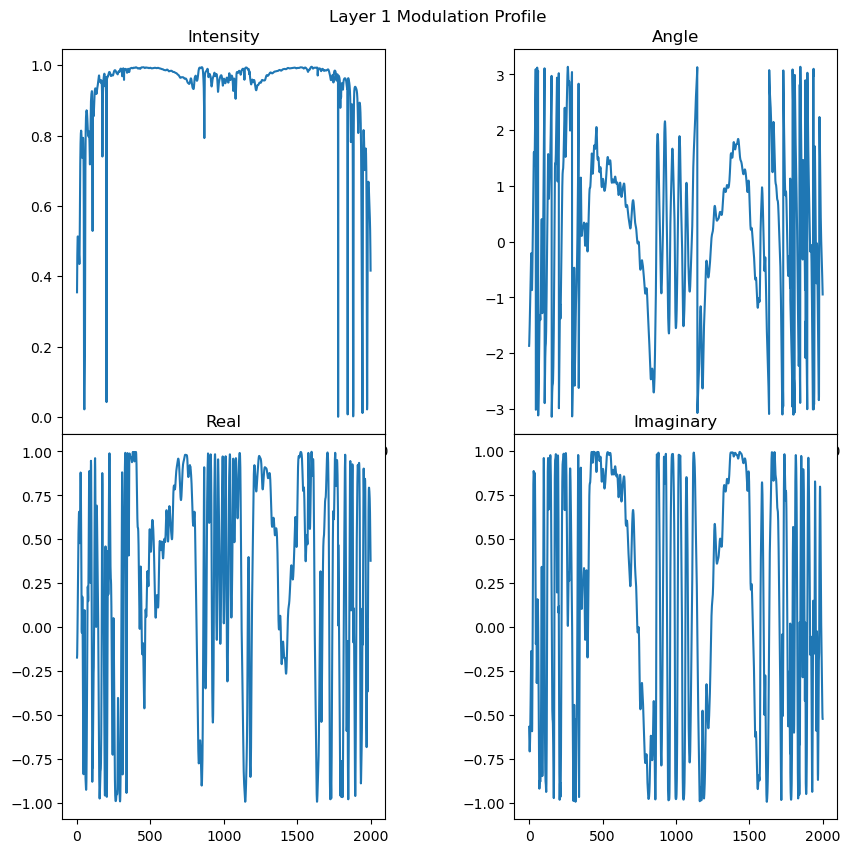

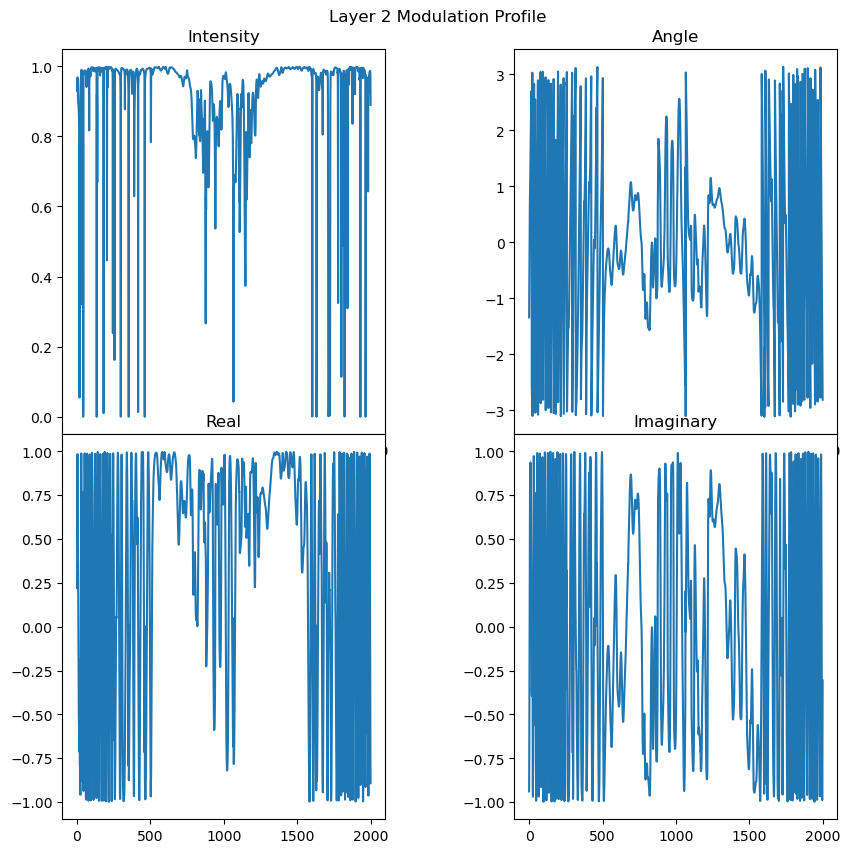

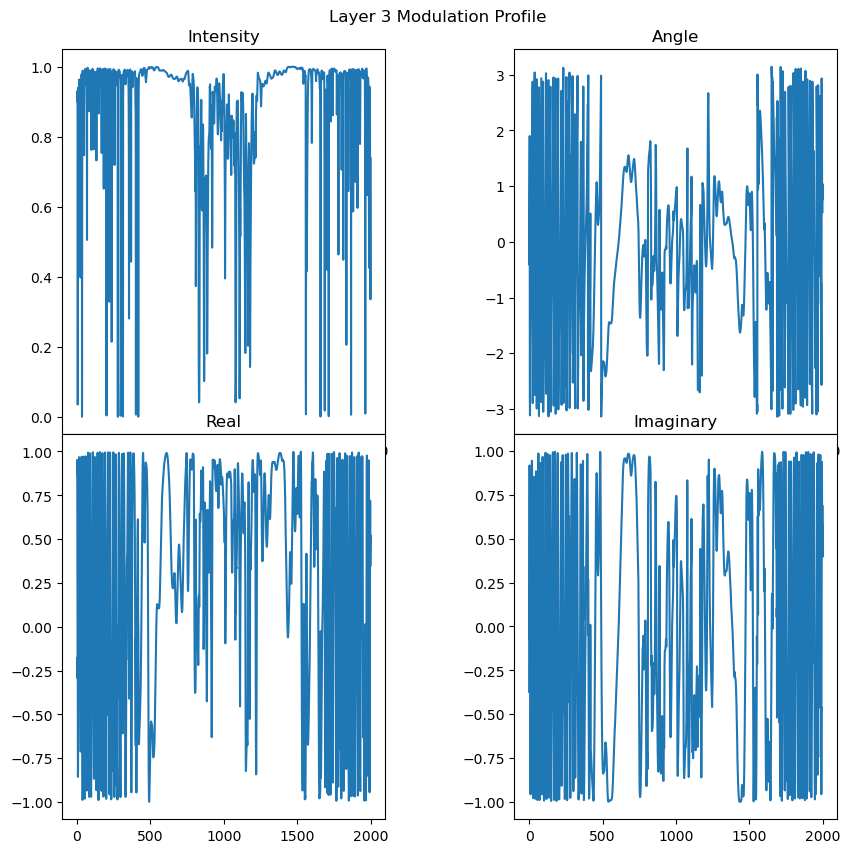

C:\Users\TF\AppData\Local\Temp\ipykernel_4908\1937215847.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test = torch.tensor(test, dtype=torch.cfloat, device='cuda')


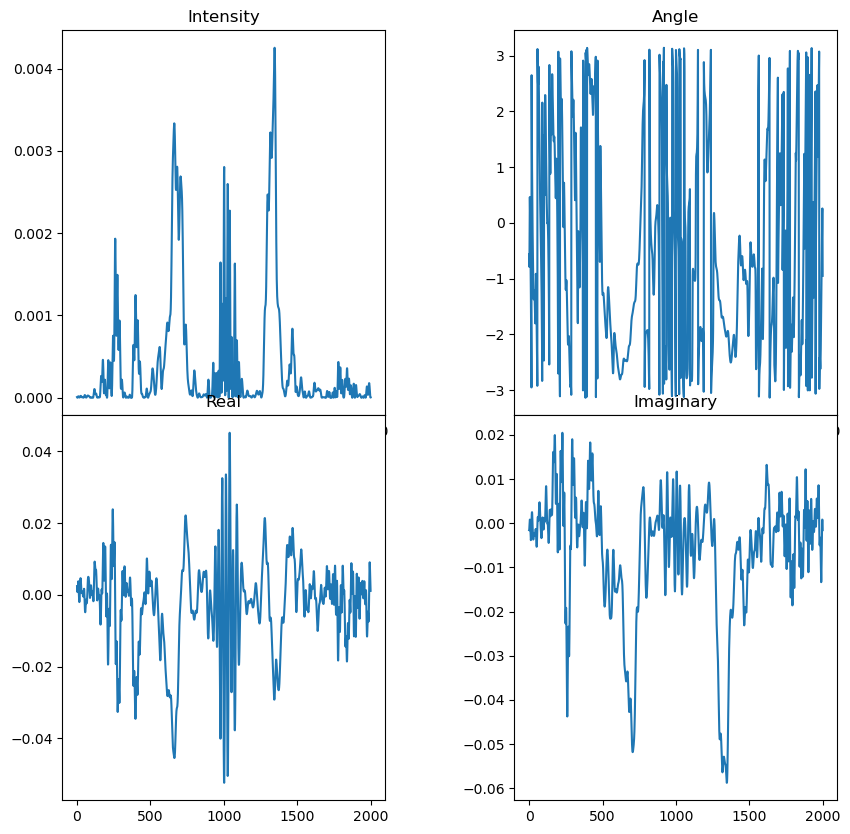

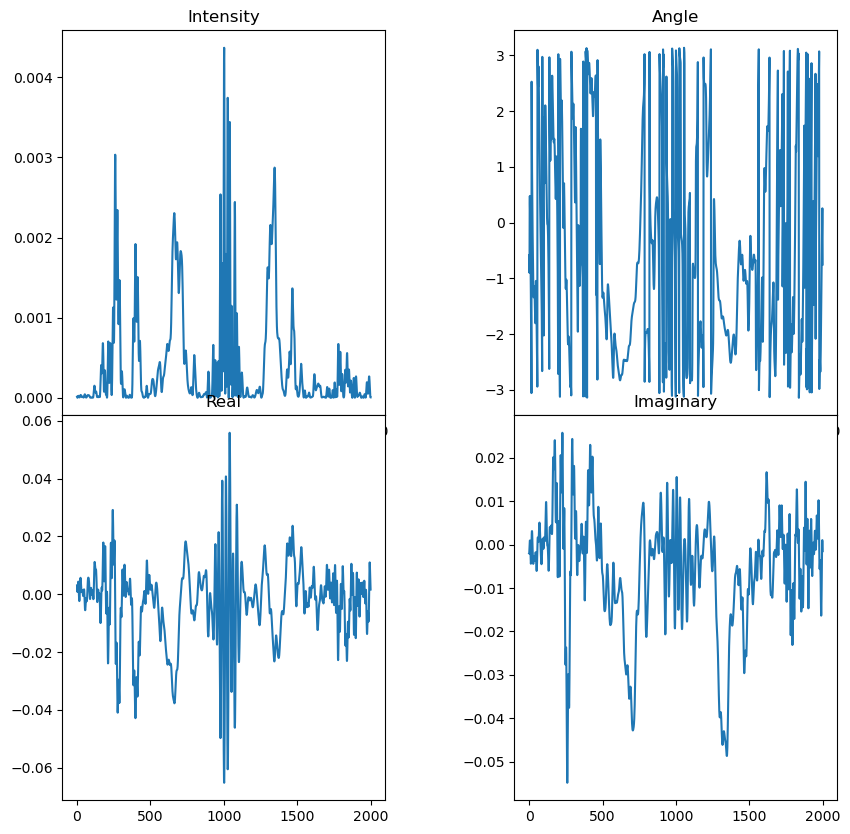

In [98]:
diffml.plot_system_layers(diffml_model)

diffml_model.eval()
diffml_model.to('cuda')

test = torch.tensor(test, dtype=torch.cfloat, device='cuda')

output_test = diffml_model(test)
plot_field(output_test)

single_slit.to('cuda')
output_single = diffml_model(single_slit.to('cuda'))
plot_field(output_single)

In [104]:
import matplotlib.pyplot as plt

cumu_out = []
cumu_sep = []
cumu_int = [] 

output_image = []
device = 'cpu'
for i, (data, target) in enumerate(val_loader):
    diffml_model.eval()
    digital_NN.eval()
    data, target = data.to('cpu'), target.to('cpu')
    output, output_intensity, image = calc_output(diffml_model, digital_NN, data, noise=True)
    
    cumu_out.append(output.detach().numpy())
    cumu_sep.append(target.numpy())
    cumu_int.append(output_intensity.detach().numpy())
    output_image.append(image.detach().numpy())
    
cumu_out = np.array(cumu_out).flatten()
cumu_sep = np.array(cumu_sep).flatten()
cumu_int = np.array(cumu_int).flatten()
#bias = cumu_out-cumu_sep

Text(0, 0.5, 'predicted separation/unit')

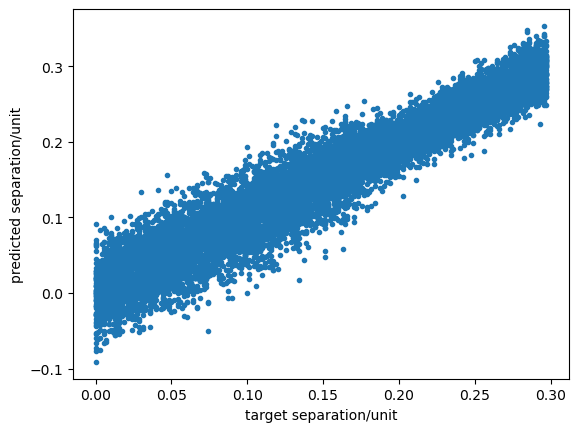

In [105]:
cumu_out = cumu_out - bias
plt.scatter(cumu_sep, cumu_out, marker = '.')
plt.xlabel('target separation/unit')
plt.ylabel('predicted separation/unit')

1894.7003697193782

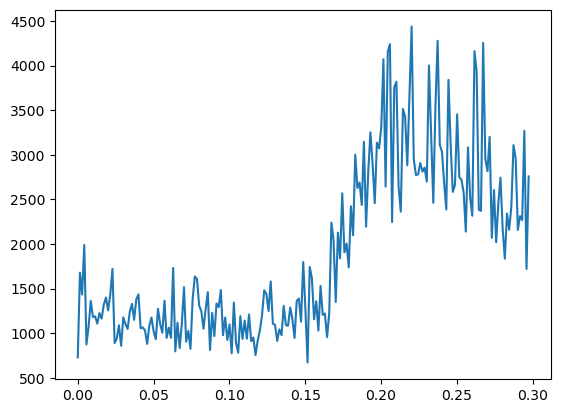

In [106]:
import statistics
from collections import defaultdict

def process_output_stat(output_stat):
    cumu_sep, cumu_out = output_stat

    # Combine and sort the data by cumu_sep
    combined = sorted(zip(cumu_sep, cumu_out), key=lambda x: x[0])

    # Group cumu_out values by cumu_sep and calculate statistics
    grouped = defaultdict(list)
    for sep, out in combined:
        grouped[sep].append(float(out))

    # Prepare the result list
    result_3_by_n = [[], [], [], [], []]
    for sep in sorted(grouped):
        out_values = grouped[sep]
        number_repeat = len(out_values)
        mean_out = statistics.mean(out_values)
        variance_out = statistics.variance(out_values) if len(out_values) > 1 else 0.0
        reciprocal_variance = 1.0 / variance_out if 1/variance_out <= 1e6 else 0
        result_3_by_n[0].append(sep)
        result_3_by_n[1].append(mean_out)
        result_3_by_n[2].append(variance_out)
        result_3_by_n[3].append(reciprocal_variance)
        result_3_by_n[4].append(number_repeat)
    return result_3_by_n

output_stat = [cumu_sep, cumu_out]
result_stat = process_output_stat(output_stat)

plt.plot(result_stat[0], result_stat[3])
statistics.mean(result_stat[3])

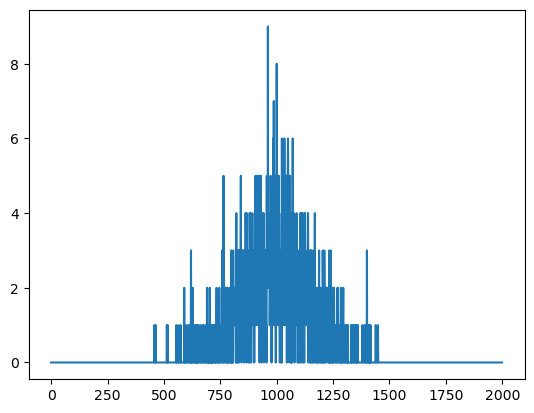

In [31]:
plt.plot(output_image[1][6])


Text(0, 0.5, 'log loss')

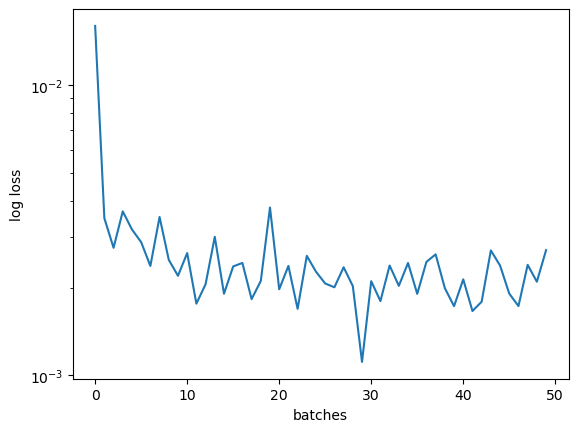

In [23]:
plt.plot(tot_loss)
plt.yscale('log')
plt.xlabel('batches')
plt.ylabel('log loss')

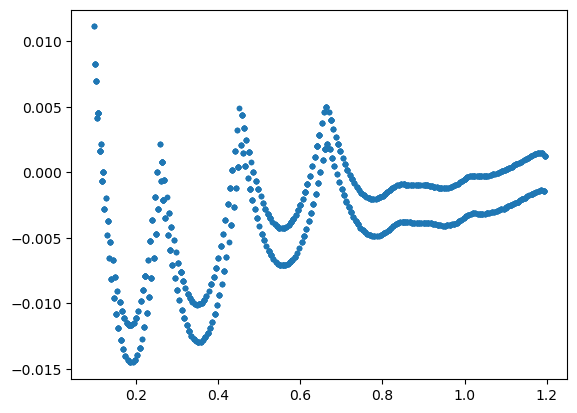

In [110]:
plt.scatter(cumu_sep, cumu_out-cumu_sep, marker = '.')

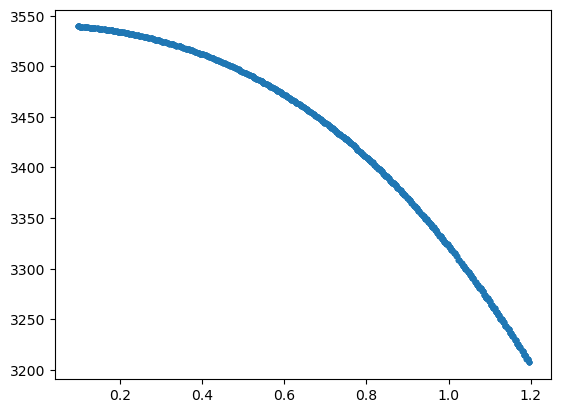

In [117]:
plt.scatter(cumu_sep, cumu_int, marker = '.')